In [24]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
import os
import time
import pickle
import json
from multiprocessing import Pool
import itertools

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from bprime.utils import index_cols
from bprime.plots import surface_plot
from bprime.learn import LearnedFunction
from bprime.sim_utils import read_params, infer_types
from bprime.theory import bgs_segment, bgs_rec
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [204]:
lowess = sm.nonparametric.lowess

In [205]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


## Data

In [216]:
with open('../msprime_sims/msprime_bgs_simple.json') as f:
    sim_config = json.load(f)
sim_params = sim_config['params']
sim_config

{'name': 'msprime_bgs_simple',
 'params': {'N': {'lower': 1000, 'upper': 1000, 'log10': False, 'type': 'int'},
  'mu': {'lower': 5.5e-09, 'upper': 1e-08, 'log10': False, 'type': 'float'},
  's': {'lower': -4, 'upper': -1, 'log10': True, 'type': 'float'},
  'r': {'lower': 1e-08, 'upper': 1e-08, 'log10': False, 'type': 'float'},
  'L': {'lower': 100000, 'upper': 100000, 'log10': False, 'type': 'int'}}}

In [217]:
read_params(sim_config), infer_types(read_params(sim_config))

({'N': (1000, 1000, False),
  'mu': (5.5e-09, 1e-08, False),
  's': (-4.0, -1.0, True),
  'r': (1e-08, 1e-08, False),
  'L': (100000, 100000, False)},
 {'N': int, 'mu': float, 's': float, 'r': float, 'L': int})

In [218]:
sim_data = np.load('../data/msprime_sims/msprime_bgs_simple.npz', allow_pickle=True)

In [219]:
sim_data['features'], sim_data['targets']

(array(['N', 'mu', 's', 'r', 'L'], dtype='<U2'), array(['Bhat'], dtype='<U4'))

In [220]:
assert(len(sim_data['features']) == sim_data['X'].shape[1])

In [221]:
Xo, y = np.array(sim_data['X']), sim_data['y']

In [222]:
# remove some fixed columns
Xcols = index_cols(sim_data['features'])
#keep_cols = ('mu', 's', 'rbp', 'rf') 
keep_cols = ('mu', 's') 
X = Xo[:, Xcols(*keep_cols)]

[]

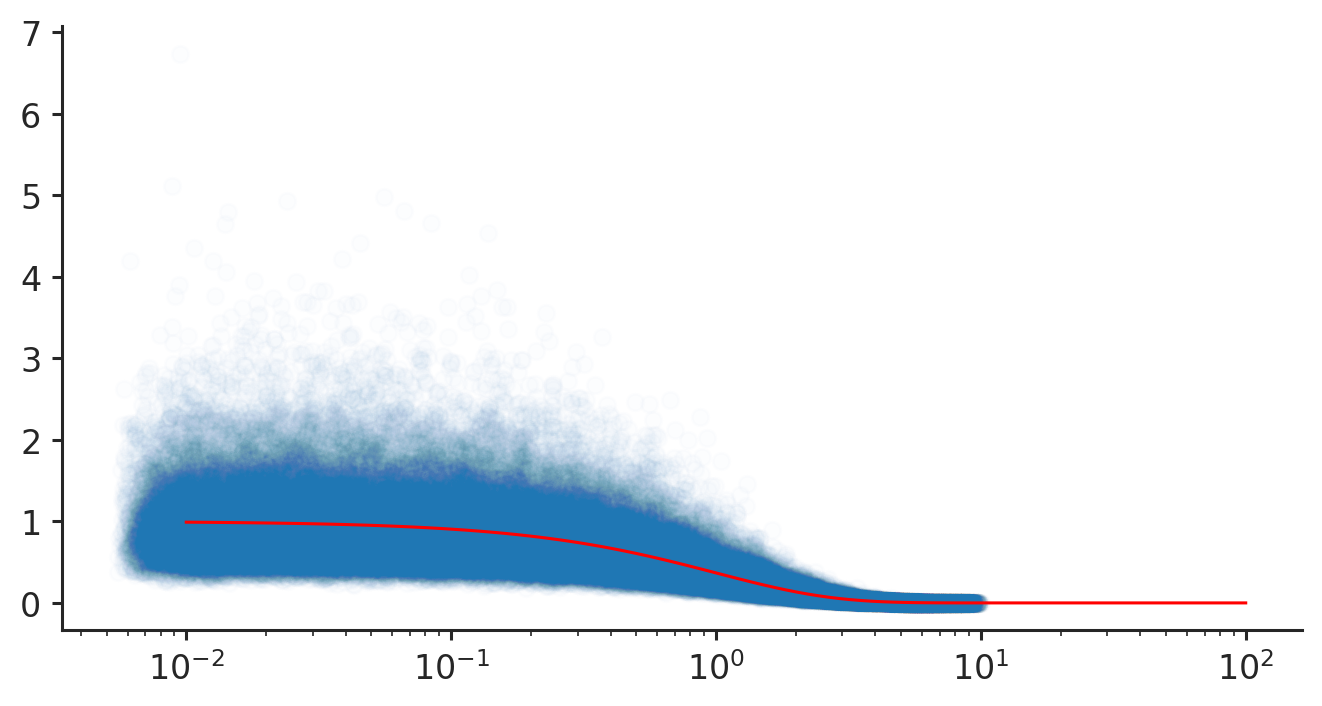

In [223]:
fig, ax = plt.subplots()
L = 100_000
ax.scatter(L*X[:, 0] / X[:, 1], y, alpha=0.01)
mu = np.logspace(-9, -8, 100)
s = np.logspace(-6, -1, 100)
gr = np.meshgrid(mu, s)
btheory = bgs_rec(mu, s, 1e-8, L)
rate = L*(mu/s).flatten()
idx = np.argsort(rate)
ax.plot(rate[idx], btheory[idx], c='r')
ax.semilogx()

In [224]:
X[:, 1].min(), X[:, 1].max()

(0.0001, 0.09999)

To be aligned with classic BGS theory, let's parameterize the heterozygous effect as $sh$. We build up our training dataset:

In [225]:
domain = {p: sim_params[p] for p in keep_cols}
func = LearnedFunction(X, y, domain=domain)
func

LearnedFunction with 2 feature(s) and 1 target(s)
 feature(s):
  - mu ∈ [5.5e-09, 1e-08] (linear, None)
  - s ∈ [-4, -1] (log10, None)
Features normalized? False
Features split? False

In [226]:
Xcols = func.col_indexer()

In [227]:
func.split(random_state=6)

LearnedFunction with 2 feature(s) and 1 target(s)
 feature(s):
  - mu ∈ [5.5e-09, 1e-08] (linear, None)
  - s ∈ [-4, -1] (log10, None)
Features normalized? False
Features split? True, test size: 10.0%

In [228]:
func.bounds

{'mu': (5.5e-09, 1e-08), 's': (-4, -1)}

In [169]:
# use the original scales
feature_transforms = {k: {True: np.log10, False: None}[v['log10']] for k, v in sim_params.items()}
func.scale_features(transforms = feature_transforms)

LearnedFunction with 2 feature(s) and 1 target(s)
 feature(s):
  - mu ∈ [5.5e-09, 1e-08] (linear, None)
  - s ∈ [-4, -1] (log10, <ufunc 'log10'>)
Features normalized? True
Features split? True, test size: 10.0%

## Network and Training

In [232]:
def network(input_size=2, n64=4, n32=2, output_activation='sigmoid'):
    # build network
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(input_size,)))
    for i in range(n64):
        model.add(layers.Dense(64, activation='elu'))
    for i in range(n32):
        model.add(layers.Dense(32, activation='elu'))
    model.add(tf.keras.layers.Dense(1, activation=output_activation))
    model.compile(
        optimizer='Adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['MeanAbsoluteError'],
        )
    return model

In [ ]:
model = network(output_activation='sigmoid')
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                   patience=50, restore_best_weights=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

history = model.fit(func.X_train, func.y_train, 
                    validation_split=0.2, 
                    #validation_data=(X_test_normalized, y_test),
                    batch_size=64, epochs=200, verbose=0, callbacks=[es, tqdm_callback])

func.model = model

Training:   0%|                                                                                               …

In [ ]:
predict = func.predict_test()
np.mean((predict - func.y_test)**2)

In [ ]:
Xgrids, Xmesh, Xmeshcols, predict_grid = func.predict_grid(100)

In [ ]:
Xmeshcols

In [ ]:
mu_test, s_test = func.X_test[:, Xcols('mu', 's')].T
rate = mu_test/10**s_test

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 7))


norm = plt.Normalize(np.min(mu_test), np.max(mu_test))

Xnew = Xmesh[:, Xcols('mu')].squeeze()/10**Xmesh[:, Xcols('s')].squeeze()
idx = np.argsort(Xnew)
ax1.plot(Xnew[idx], bgs_rec(Xmesh[idx, Xcols('mu')], 10**Xmesh[idx, Xcols('s')], r=1e-8, L=100000))
ax1.scatter(rate, predict, c=mu_test, cmap='viridis', s=8)
ax1.set_xlabel("$\mu/s$")
ax1.set_ylabel("predicted")
ax1.semilogx()
#cax1 = fig.add_axes([0.27, 0.8, 0.5, 0.05])
#fig.colorbar(cmap=cm.viridis, cax=cax1, orientation='horizontal')

#n = 10
#yedges = np.linspace(y_test.min(), y_test.max(), n)
#xedges = np.linspace(predict.min(), predict.max(), n)
#H, xedges, yedges = np.histogram2d(y_test.squeeze(), predict, bins=(xedges, yedges))
#X, Y = np.meshgrid(xedges, yedges)
#ax3.pcolormesh(X, Y, H)
ax3.scatter(func.y_test, predict, c=func.X_test[:, 1], s=5)
ax3.axline((0, 0), slope=1, c='r')
ax3.set_xlabel('y')
ax3.set_ylabel('predicted')

ly = (predict - func.y_test.squeeze())**2
lX = predict
ax4.scatter(lX, ly, color='0.44', 
            linewidth=0, edgecolor='black', alpha=0.2)
#ax4.set_ylim(-0.1, 3)
z = lowess(ly, lX, frac= 1/10, it=0)
ax4.plot(z[:, 0], z[:, 1], c='r', linewidth=2)

# the lowess fit was sensitive to it=0; this shows that the it=0 
# case is nearly identical to OLS, e.g. right thing to do
#mod = sm.OLS(ly, sm.add_constant(lX))
#res = mod.fit()
#lX_new = sm.add_constant(np.linspace(0.4, 1, 100))
#ax4.plot(lX_new, res.predict(lX_new), c='g')

xnew = np.linspace(0.4, 1, 100)
def B_var_limit(B, N, mu=1):
    return (3*mu + 8*B*N*mu**2)/(36*B*N)
ax4.axhline(B_var_limit(1, 1000), c='0.22', linewidth=1.6, linestyle='dashed') # Note the 1/2 factor — see sim_power.ipynb! TODO
#ax4.text(0.03, 0.88, "$\sigma^2 = \\frac{3 \mu + 8 B N \mu}{36 B N}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax4.text(0.03, 0.88, "$\sigma^2 \\approx \\frac{2}{9}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax4.semilogy()
ax4.set_ylabel('validation loss')
ax4.set_xlabel('predicted')

ax2.plot(history.history['loss'][1:], label='training loss')
ax2.plot(history.history['val_loss'][1:], label='validation loss')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epoch")
#ax2.set_ylim((0, 1))
ax2.legend()
plt.tight_layout()

In [ ]:
y_theory = bgs_rec(mu=func.X_test_orig[:, Xcols('mu')],
                   s=10**func.X_test_orig[:, Xcols('s')], 
                   r=1e-8, L=100000)

X_theory = func.X_test_orig[:, Xcols('mu', 's')]
          
predict_theory = func.predict(X_theory)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#points_yhat = ax1.scatter(y_test, predict, label='actual = $y_\mathrm{test}$')
points_ytheory = ax1.scatter(y_theory, predict_theory, c='orange', label='actual = $y_\mathrm{theory}$')
ax1.legend()
#points_yhat.set_alpha(0.1)
#points_ytheory.set_alpha(0.1)


ax1.axline((0, 0), slope=1, c='r')
ax2.plot(history.history['loss'][1:], label='training loss')
ax2.plot(history.history['val_loss'][1:], label='validation loss')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epoch")
ax1.set_xlabel("actual")
ax1.set_ylabel("predicted")
#ax2.set_ylim((0, 1))
ax2.legend()
plt.tight_layout()

In [58]:
y_theory = bgs_rec(X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 3])


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
points_yhat = ax1.scatter(y_test, predict, label='actual = $y_\mathrm{test}$')
points_ytheory = ax1.scatter(y_theory, predict, c='orange', label='actual = $y_\mathrm{theory}$')
ax1.legend()
points_yhat.set_alpha(0.1)
points_ytheory.set_alpha(0.1)


ax1.axline((0, 0), slope=1, c='r')
ax2.plot(history.history['loss'][1:], label='training loss')
ax2.plot(history.history['val_loss'][1:], label='validation loss')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epoch")
ax1.set_xlabel("actual")
ax1.set_ylabel("predicted")
#ax2.set_ylim((0, 1))
ax2.legend()
plt.tight_layout()

NameError: name 'X_test' is not defined

In [ ]:
np.abs(predict.flatten() - y_test.flatten()).mean(), np.abs(predict.flatten() - y_theory.flatten()).mean()

In [ ]:
n = 100
s = np.random.uniform(1e-3, 1e-1, n)
mu = np.random.uniform(1e-8, 1e-8, n)
rbp = np.random.uniform(1e-7, 1e-9, n)
L = np.random.uniform(10, 100_000, n)
N = np.random.uniform(50, 10_000, n)
xnew = np.array((mu, s, rbp, N, L)).T

#'N', 's', 'h', 'mu', 'recfrac', 'rbp', 'seglen'
xnew = np.array((mu, s, rbp, L)).T
rate = xnew[:, 0]/xnew[:, 1]
fig, ax = plt.subplots()
ax.scatter(rate, model.predict(X_scaler.transform(xnew)))
ax.scatter(rate, bgs_rec(mu, s, rbp, L))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mu/s$')
ax.set_ylabel('B')